Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import os

In [4]:
import torch
import torch.nn.functional as F

from torch import nn
from einops import rearrange

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

In [31]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd hw4_train
# !rm -r .data
# !find . -name '.DS_Store' -type f -delete
# !ls -a
# %cd ..

C:\Users\sidd3\Documents\UCSB\Spring 2022\CS165B\HW4\hw4_train


'rm' is not recognized as an internal or external command,
operable program or batch file.
FIND: Parameter format not correct


C:\Users\sidd3\Documents\UCSB\Spring 2022\CS165B\HW4


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
main_dir = "hw4_train"

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor


# data_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
#                                      transforms.ToTensor()])

train_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=0.1793, std=0.2323)
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=0.1793, std=0.2323)
                                     ])

train_data = ImageFolder(main_dir, transform=train_transforms)

In [6]:
train_data.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [7]:
from torch.utils.data import DataLoader 

loader = DataLoader(train_data, batch_size=1, num_workers=4)
print(loader)

mstd = next(iter(loader))
print("Mean", mstd[0].mean())
print("Std",  mstd[0].std())

Mean tensor(-0.0330)
Std tensor(0.9696)


In [8]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

In [9]:
train_data, valid_data = torch.utils.data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [10]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = train_transforms

In [11]:
BATCH_SIZE = 64

train_iterator = torch.utils.data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE,)

valid_iterator = torch.utils.data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE,)

# test_iterator = data.DataLoader(test_data,
#                                 batch_size=BATCH_SIZE)

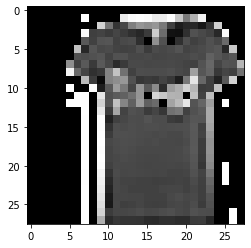

AttributeError: 'int' object has no attribute 'numpy'

In [12]:
for x in train_data[0]:
  arr = x.numpy()
  arr_ = np.squeeze(arr)
  plt.imshow(arr_, cmap='gray')
  plt.show()


In [ ]:
def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if i == 5:
            break

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())

In [ ]:
def evaluate(model, data_loader, loss_history):
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage validation loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')
    return avg_loss

In [ ]:
N_EPOCHS = 30

start_time = time.time()
model = ViT(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128)
optimizer = optim.Adam(model.parameters(), lr=0.003)

best_loss = 90000000
PATH = F"second.pth"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
train_loss_history, val_loss_history = [], []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_iterator, train_loss_history)
    loss = evaluate(model, valid_iterator, val_loss_history)
    if loss < best_loss:
      best_loss = loss
      torch.save(model.state_dict(), PATH)
      print("New best loss & New model saved")


print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1
[    0/45360 (  0%)]  Loss: 2.4268

Average validation loss: 2.1541  Accuracy: 1078/ 5040 (21.39%)

New best loss & New model saved
Epoch: 2
[    0/45360 (  0%)]  Loss: 2.2780

Average validation loss: 2.0990  Accuracy:  925/ 5040 (18.35%)

New best loss & New model saved
Epoch: 3
[    0/45360 (  0%)]  Loss: 2.0830

Average validation loss: 1.9311  Accuracy: 1244/ 5040 (24.68%)

New best loss & New model saved
Epoch: 4
[    0/45360 (  0%)]  Loss: 1.8925

Average validation loss: 1.9005  Accuracy: 1378/ 5040 (27.34%)

New best loss & New model saved
Epoch: 5
[    0/45360 (  0%)]  Loss: 1.8852

Average validation loss: 1.7722  Accuracy: 1679/ 5040 (33.31%)

New best loss & New model saved
Epoch: 6
[    0/45360 (  0%)]  Loss: 1.7722

Average validation loss: 1.5590  Accuracy: 1892/ 5040 (37.54%)

New best loss & New model saved
Epoch: 7
[    0/45360 (  0%)]  Loss: 1.6760

Average validation loss: 1.6262  Accuracy: 1657/ 5040 (32.88%)

Epoch: 8
[    0/45360 (  0%)]  Loss: 1.8275



In [25]:
from torch.utils.data import DataLoader 
from torch.utils.data import Dataset
from PIL import Image
import natsort

def test(model, data_loader):
    model.eval()

    with open('prediction.txt', 'w') as f:
      with torch.no_grad():
          for data in test_loader:
              output = F.log_softmax(model(data), dim=1)
              _, pred = torch.max(output, dim=1)
              for i in pred.numpy():
                f.write(str(i))
                f.write('\n')
      f.close()


class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = all_imgs

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc)
        tensor_image = self.transform(image)
        return tensor_image

In [33]:
# %cd hw4_test
# !find . -name '. DS_Store' -type f -delete
# %cd ..

test_path = 'hw4_test' 

my_dataset = CustomDataSet(test_path, transform=train_transforms)
test_loader = data.DataLoader(my_dataset, batch_size=50, shuffle=False, drop_last = True)

PATH = "second.pth"
model = ViT(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128)
model.load_state_dict(torch.load (PATH))
test(model, test_loader)